# Submap Evaluation
This notebook performs several simulated tests with trajectories:
 * **Test 1:** Sanity test, compares the same trajectory.
 * **Test 2:** Translates one trajectory and compares it.
 * **Test 3:** Scales one trajectory and compares it.
 * **Test 4:** Adds additive normal distributed noise and compares it.
 * **Test 5:** Adds multiplicative normal distributed noise and compares it.

In [246]:
import numpy as np
import matplotlib.pyplot as plt
from pygsp import graphs, filters, plotting, reduction
import pandas
from enum import Enum
import scipy.spatial
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import seaborn as sns
from sklearn.tree import export_graphviz
import pydot
import pickle
from joblib import dump, load


%load_ext autoreload
%autoreload 2
%matplotlib inline

plotting.BACKEND = 'matplotlib'
plt.rcParams['figure.figsize'] = (10, 5)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [154]:
class SubmapState(Enum):
    ALL_GOOD = 1
    LOW_GOOD = 2
    BAND_GOOD = 3
    HIGH_GOOD = 4
    NO_GOOD = 5

class WaveletEvaluator(object):

    def __init__(self, n_scales = 7):
        self.n_scales = n_scales

    def set_scales(self, n_scales):
        self.n_scales = n_scales

    def compare_signals(self, G, x_1, x_2):

        # Compute the wavelets for each node and scale.
        psi = self.compute_wavelets(G)
        print(f"[WaveletEvaluator] psi = {psi.shape}")

        # Compute the wavelet coefficients for x_1 and x_2.
        W_1 = self.compute_wavelet_coefficients(psi, x_1)
        W_2 = self.compute_wavelet_coefficients(psi, x_2)
        print(f"[WaveletEvaluator] W_1 = {W_1.shape}")
        print(f"[WaveletEvaluator] W_2 = {W_2.shape}")


    def compute_wavelets(self, G):
        print(f"[WaveletEvaluator] Computing wavelets for {self.n_scales}")
        g = filters.Meyer(G, self.n_scales)

        # Evalute filter bank on the frequencies (eigenvalues).
        f = g.evaluate(G.e)
        f = np.expand_dims(f.T, 1)
        psi = np.zeros((G.N, G.N, self.n_scales))

        for i in range(0, G.N):

            # Create a Dirac centered at node i.
            x = np.zeros((G.N,1))
            x[i] = 1

            # Transform the signal to spectral domain.
            s = G._check_signal(x)
            s = G.gft(s)

            # Multiply the transformed signal with filter.
            if s.ndim == 1:
                s = np.expand_dims(s, -1)
            s = np.expand_dims(s, 1)
            s = np.matmul(s, f)

            # Transform back the features to the vertex domain.
            psi[i, :, :] = G.igft(s).squeeze()

        return psi

    def compute_wavelets_coeffs(self, wavelet, x_signal):
        n_values = x_signal.shape[0]
        W = np.zeros((n_values, self.n_scales))
        for i in range(0, n_values):
            for j in range(0, self.n_scales):
                W[i,j] = np.matmul(wavelet[i,:,j].transpose(), x_signal)

        return W

    def check_submap(self, coeffs_1, coeffs_2, submap_ids):
        submap_coeffs_1 = coeffs_1[submap_ids, :]
        submap_coeffs_2 = coeffs_2[submap_ids, :]

        D = self.compute_generic_distance(submap_coeffs_1, submap_coeffs_2)
        #D = self.compute_cosine_distance(submap_coeffs_1, submap_coeffs_2)
        #print(f"dist: {D.transpose()}")
        return self.evaluate_scales(D)
    
    def compute_features_for_submap(self, coeffs_1, coeffs_2, submap_ids):
        submap_coeffs_1 = coeffs_1[submap_ids, :]
        submap_coeffs_2 = coeffs_2[submap_ids, :]
        
        D = self.compute_distances(submap_coeffs_1, submap_coeffs_2)
              
        
        
        data = np.array([
            np.sum(D[0, 0:2]),
            np.sum(D[0, 2:4]),
            np.sum(D[0, 5:]),
            
            np.sum(D[1, 0:2]),
            np.sum(D[1, 2:4]),
            np.sum(D[1, 5:]),
            
            np.sum(D[2, 0:2]),
            np.sum(D[2, 2:4]),
            np.sum(D[2, 5:]),
            
            np.sum(D[3, 0:2]),
            np.sum(D[3, 2:4]),
            np.sum(D[3, 5:]),
        ])
        
        return data
        

    def compute_cosine_distance(self, coeffs_1, coeffs_2):
        #print(f"c1 {coeffs_1.shape} and c2 {coeffs_2.shape}")
        cosine_distance = np.zeros((self.n_scales, 1))
        for j in range(0, self.n_scales):
            cross = np.dot(coeffs_1[:,j], coeffs_2[:,j])
            n_1 = np.linalg.norm(coeffs_1[:,j])
            n_2 = np.linalg.norm(coeffs_2[:,j])


            cosine_similarity = cross/(n_1*n_2)
            cosine_distance[j] = 1 - cosine_similarity
        return cosine_distance
    
    def compute_distances(self, coeffs_1, coeffs_2):
        distances = np.zeros((4, self.n_scales))            
        for j in range(0, self.n_scales):      
            #w = np.abs(np.divide(coeffs_1[:,j], coeffs_2[:,j]))
            distances[0, j] = scipy.spatial.distance.cosine(coeffs_1[:,j], coeffs_2[:,j])
            distances[1, j] = scipy.spatial.distance.euclidean(coeffs_1[:,j], coeffs_2[:,j])
            distances[2, j] = scipy.spatial.distance.braycurtis(coeffs_1[:,j], coeffs_2[:,j])
            distances[3, j] = scipy.spatial.distance.correlation(coeffs_1[:,j], coeffs_2[:,j])
        return distances

    def evaluate_scales(self, D):
        k_eps = 0.3
        
        sum_lower = np.sum(D[0:2])
        print(f"Lower sum resulting in {sum_lower.transpose()}")
        
        sum_band = np.sum(D[2:4])
        print(f"Band sum resulting in {sum_band.transpose()}")
        
        sum_higher = np.sum(D[5:])
        print(f"Higher sum resulting in {sum_higher.transpose()}")
        sum_total = sum_lower + sum_higher
        print(f"--------------------")

        if (sum_total < k_eps):
            return SubmapState.ALL_GOOD
        elif (sum_lower < k_eps and sum_higher >= k_eps):
            return SubmapState.LOW_GOOD
        elif (sum_lower >= k_eps and sum_higher < k_eps):
            return SubmapState.HIGH_GOOD
        else:
            return SubmapState.NO_GOOD

### Load Input from File

In [3]:
dataset_path = '/home/berlukas/Documents/workspace/fgsp_ws/src/fgsp/data/mission_03/adj_test/'
graph_file = dataset_path + 'cdpgo_graph.csv'
signal_file = dataset_path + 'cdpgo_signal.csv'
adj_file = dataset_path + 'cdpgo_adj.csv'

graph_labels = ['ts', 'qw', 'qx', 'qy', 'qz', 'x', 'y', 'z']
signal_labels = ['residual']
graph_df = pandas.read_csv(graph_file, names=graph_labels, delimiter=',', header=0)
signal_df = pandas.read_csv(signal_file, names=signal_labels, delimiter=',', header=None)
#adj_df = pandas.read_csv(adj_file, delimiter=' ', header=None)
adj = np.genfromtxt(adj_file, dtype=float)


print(f'\nRead {graph_df.size} (graph) and {signal_df.size} (signal)  entries.')
print(f'\nShape of the adjacency matrix {adj.shape}')

dataset_path = '/home/berlukas/Documents/workspace/fgsp_ws/src/fgsp/data/mission_03/'
loam_file = dataset_path + 'loam_header_less.csv'
rovio_file = dataset_path + 'rovio_header_less.csv'
opt_file = dataset_path + 'opt_header_less.csv'

labels = ['ts', 'vertex-id', 'mission_id', 'p_G_Ix', 'p_G_Iy', 'p_G_Iz', 'q_G_Iw', 'q_G_Ix', 'q_G_Iy', 'q_G_Iz', 'p_M_Ix', 'p_M_Iy', 'p_M_Iz', 'q_M_Iw', 'q_M_Ix', 'q_M_Iy', 'q_M_Iz', 'v_Mx', 'v_My', 'v_Mz', 'bgx', 'bgy', 'bgz', 'bax', 'bay', 'baz']
loam_df = pandas.read_csv(loam_file, names=labels, delimiter=',', header=None)
rovio_df = pandas.read_csv(rovio_file, names=labels, delimiter=',', header=None)
opt_df = pandas.read_csv(opt_file, names=labels, delimiter=',', header=None)

print(f'\nRead {loam_df.size} (loam), {rovio_df.size} (rovio) and {opt_df.size} (opt)  entries.')

loam_ts = loam_df[['ts']].to_numpy()
rovio_ts = rovio_df[['ts']].to_numpy()
opt_ts = opt_df[['ts']].to_numpy()
server_ts = graph_df[['ts']].to_numpy()

server_size = server_ts.shape[0]

print(f'Processing {server_size} optimized entries.')
loam_idx = np.zeros((server_size, 1))
rovio_idx = np.zeros((server_size, 1))
opt_idx = np.zeros((server_size, 1))

for i in range(0, server_size):
    cur_ts = server_ts[i,0]    
        
    loam_ts_diff = np.absolute(loam_ts - cur_ts)    
    cur_min_loam_index = np.where(loam_ts_diff == np.amin(loam_ts_diff))[0]    
    loam_idx[i] = cur_min_loam_index[0]
    
    rovio_ts_diff = np.absolute(rovio_ts - cur_ts)
    cur_min_rovio_index = np.where(rovio_ts_diff == np.amin(rovio_ts_diff))[0]
    rovio_idx[i] = cur_min_rovio_index[0]
    
    opt_ts_diff = np.absolute(opt_ts - cur_ts)
    cur_min_opt_index = np.where(opt_ts_diff == np.amin(opt_ts_diff))[0]
    opt_idx[i] = cur_min_opt_index[0]
    
loam_graph = loam_df[['p_G_Ix', 'p_G_Iy', 'p_G_Iz']].to_numpy()
rovio_graph = rovio_df[['p_G_Ix', 'p_G_Iy', 'p_G_Iz']].to_numpy()
opt_graph = opt_df[['p_G_Ix', 'p_G_Iy', 'p_G_Iz']].to_numpy()
loam_graph = loam_graph[loam_idx.astype(int),:].squeeze()
rovio_graph = rovio_graph[rovio_idx.astype(int),:].squeeze()
opt_graph = opt_graph[opt_idx.astype(int),:].squeeze()

loam_origin = loam_graph[0,:]
rovio_origin = rovio_graph[0,:]
opt_origin = opt_graph[0,:]

loam_pos_signal = (loam_graph - loam_origin).squeeze()
rovio_pos_signal = (rovio_graph - rovio_origin).squeeze()
opt_pos_signal = (opt_graph - opt_origin).squeeze()

x_loam = np.linalg.norm(loam_pos_signal, ord=2, axis=1)
x_rovio = np.linalg.norm(rovio_pos_signal, ord=2, axis=1)
x_opt = np.linalg.norm(opt_pos_signal, ord=2, axis=1)


Read 8664 (graph) and 1083 (signal)  entries.

Shape of the adjacency matrix (1083, 1083)

Read 27690 (loam), 27768 (rovio) and 12220 (opt)  entries.
Processing 1083 optimized entries.


### Graph Generation

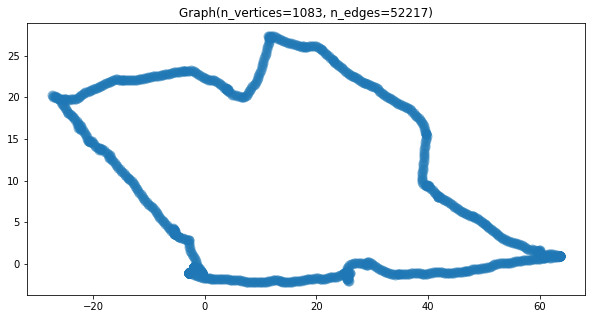

In [155]:
N = graph_df[['x', 'y']].to_numpy()
G = graphs.Graph(adj)
G.set_coordinates(N)
G.compute_fourier_basis()

G.plot()
eval = WaveletEvaluator()

In [5]:
# Compute wavelets.
psi = eval.compute_wavelets(G)
print(f" psi = {psi.shape}")

[WaveletEvaluator] Computing wavelets for 7
 psi = (1083, 1083, 7)


## Test Scenario 1

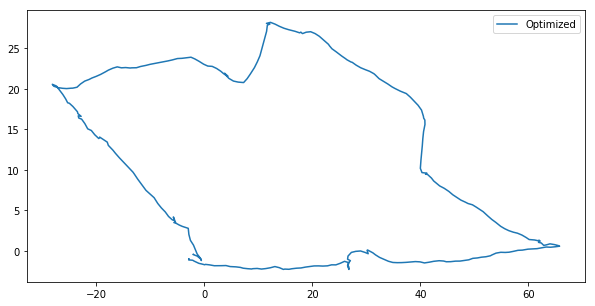

 W_1 = (1083, 7) andd W_2 = (1083, 7)


In [145]:
plt.plot(opt_graph[:, 0], opt_graph[:,1], label='Optimized')
plt.legend()
plt.show()

x_1 = np.linalg.norm(opt_graph, ord=2, axis=1)
x_2 = np.linalg.norm(opt_graph, ord=2, axis=1)

W_1 = eval.compute_wavelets_coeffs(psi, x_1)
W_2 = eval.compute_wavelets_coeffs(psi, x_2)
print(f" W_1 = {W_1.shape} andd W_2 = {W_2.shape}")

## Test Scenario 2

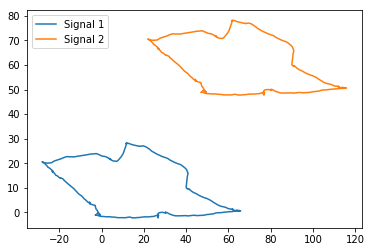

 W_1 = (1083, 7) andd W_2 = (1083, 7)


In [37]:
translation = np.array([50, 50, 15]).transpose()
shifted_opt_graph = opt_graph + translation

plt.plot(opt_graph[:, 0], opt_graph[:,1], label='Signal 1')
plt.plot(shifted_opt_graph[:, 0], shifted_opt_graph[:,1], label='Signal 2')
plt.legend()
plt.show()

opt_origin = opt_graph[0,:]
opt_pos_signal = (opt_graph - opt_origin).squeeze()

shifted_opt_origin = shifted_opt_graph[0,:]
shifted_opt_pos_signal = (shifted_opt_origin - shifted_opt_graph).squeeze()

x_1 = np.linalg.norm(opt_pos_signal, ord=2, axis=1)
x_2 = np.linalg.norm(shifted_opt_pos_signal, ord=2, axis=1)

W_1 = eval.compute_wavelets_coeffs(psi, x_1)
W_2 = eval.compute_wavelets_coeffs(psi, x_2)
print(f" W_1 = {W_1.shape} andd W_2 = {W_2.shape}")

## Test Scenario 3

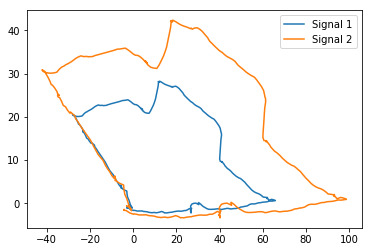

 W_1 = (1083, 7) andd W_2 = (1083, 7)


In [104]:
shifted_opt_graph = opt_graph * 1.5

plt.plot(opt_graph[:, 0], opt_graph[:,1], label='Signal 1')
plt.plot(shifted_opt_graph[:, 0], shifted_opt_graph[:,1], label='Signal 2')
plt.legend()
plt.show()

opt_origin = opt_graph[0,:]
opt_pos_signal = (opt_graph - opt_origin).squeeze()

shifted_opt_origin = shifted_opt_graph[0,:]
shifted_opt_pos_signal = (shifted_opt_origin - shifted_opt_graph).squeeze()

x_1 = np.linalg.norm(opt_pos_signal, ord=2, axis=1)
x_2 = np.linalg.norm(shifted_opt_pos_signal, ord=2, axis=1)

W_1 = eval.compute_wavelets_coeffs(psi, x_1)
W_2 = eval.compute_wavelets_coeffs(psi, x_2)
print(f" W_1 = {W_1.shape} andd W_2 = {W_2.shape}")

## Test Scenario 4

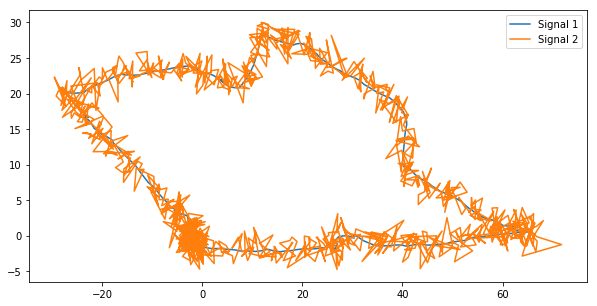

 W_1 = (1083, 7) andd W_2 = (1083, 7)


In [221]:
sigma = 1.4
samples_1 = np.random.normal(0, sigma, G.N)
samples_2 = np.random.normal(0, sigma, G.N)
samples_3 = np.random.normal(0, sigma, G.N)
shifted_opt_graph = opt_graph + np.array([samples_1, samples_2, samples_3]).transpose()

plt.plot(opt_graph[:, 0], opt_graph[:,1], label='Signal 1')
plt.plot(shifted_opt_graph[:, 0], shifted_opt_graph[:,1], label='Signal 2')
plt.legend()
plt.show()

opt_origin = opt_graph[0,:]
opt_pos_signal = (opt_graph - opt_origin).squeeze()

shifted_opt_origin = shifted_opt_graph[0,:]
shifted_opt_pos_signal = (shifted_opt_origin - shifted_opt_graph).squeeze()

x_1 = np.linalg.norm(opt_pos_signal, ord=2, axis=1)
x_2 = np.linalg.norm(shifted_opt_pos_signal, ord=2, axis=1)

W_1 = eval.compute_wavelets_coeffs(psi, x_1)
W_2 = eval.compute_wavelets_coeffs(psi, x_2)
print(f" W_1 = {W_1.shape} andd W_2 = {W_2.shape}")

## Test Scenario 5

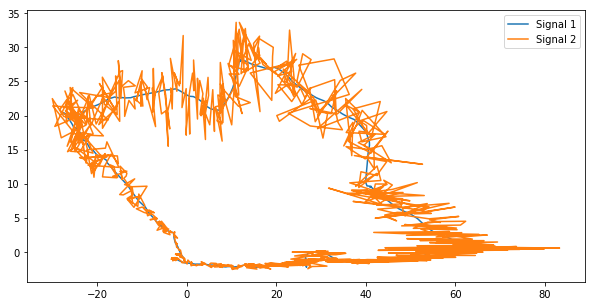

 W_1 = (1083, 7) andd W_2 = (1083, 7)


In [207]:
sigma = 0.1
samples_1 = np.random.normal(1, sigma, G.N)
samples_2 = np.random.normal(1, sigma, G.N)
samples_3 = np.random.normal(1, sigma, G.N)
shifted_opt_graph = opt_graph * np.array([samples_1, samples_2, samples_3]).transpose()

plt.plot(opt_graph[:, 0], opt_graph[:,1], label='Signal 1')
plt.plot(shifted_opt_graph[:, 0], shifted_opt_graph[:,1], label='Signal 2')
plt.legend()
plt.show()

opt_origin = opt_graph[0,:]
opt_pos_signal = (opt_graph - opt_origin).squeeze()

shifted_opt_origin = shifted_opt_graph[0,:]
shifted_opt_pos_signal = (shifted_opt_origin - shifted_opt_graph).squeeze()

x_1 = np.linalg.norm(opt_pos_signal, ord=2, axis=1)
x_2 = np.linalg.norm(shifted_opt_pos_signal, ord=2, axis=1)

W_1 = eval.compute_wavelets_coeffs(psi, x_1)
W_2 = eval.compute_wavelets_coeffs(psi, x_2)
print(f" W_1 = {W_1.shape} andd W_2 = {W_2.shape}")

## Test Scenario 6

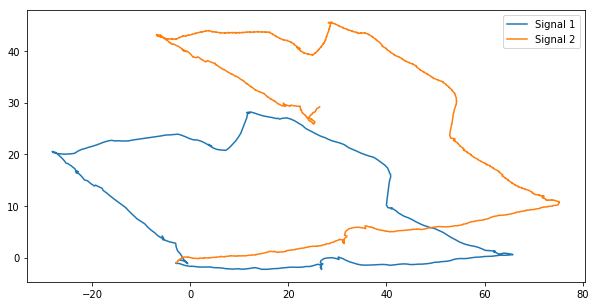

 W_1 = (1083, 7) andd W_2 = (1083, 7)


In [222]:
sigma = 0.034
noise = np.array([0.0, 0.0, 0.0])
shifted_opt_graph = np.copy(opt_graph)
for i in range(0, G.N):
    noise[0] += np.abs(np.random.normal(0, sigma, 1))
    noise[1] += np.abs(np.random.normal(0, sigma, 1))
    noise[2] += np.abs(np.random.normal(0, sigma, 1))
    shifted_opt_graph[i] += noise.transpose()

plt.plot(opt_graph[:, 0], opt_graph[:,1], label='Signal 1')
plt.plot(shifted_opt_graph[:, 0], shifted_opt_graph[:,1], label='Signal 2')
plt.legend()
plt.show()

opt_origin = opt_graph[0,:]
opt_pos_signal = (opt_graph - opt_origin).squeeze()

shifted_opt_origin = shifted_opt_graph[0,:]
shifted_opt_pos_signal = (shifted_opt_origin - shifted_opt_graph).squeeze()

x_1 = np.linalg.norm(opt_pos_signal, ord=2, axis=1)
x_2 = np.linalg.norm(shifted_opt_pos_signal, ord=2, axis=1)

W_1 = eval.compute_wavelets_coeffs(psi, x_1)
W_2 = eval.compute_wavelets_coeffs(psi, x_2)
print(f" W_1 = {W_1.shape} andd W_2 = {W_2.shape}")

## Test Scenario 6

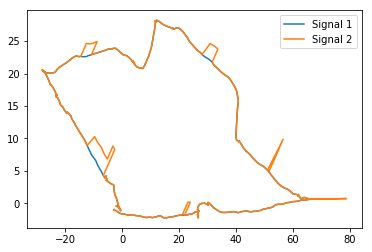

 W_1 = (1083, 7) andd W_2 = (1083, 7)


In [123]:
shifted_opt_graph = np.copy(opt_graph)
shifted_opt_graph[142:145, :] += 2
shifted_opt_graph[342:345, :] *= 1.2
shifted_opt_graph[542:555, :] += 2
shifted_opt_graph[742:755, :] += 2
shifted_opt_graph[902:925, :] += 2
shifted_opt_graph[922:925, :] += 2
shifted_opt_graph[422:423, :] += 5


plt.plot(opt_graph[:, 0], opt_graph[:,1], label='Signal 1')
plt.plot(shifted_opt_graph[:, 0], shifted_opt_graph[:,1], label='Signal 2')
plt.legend()
plt.show()

opt_origin = opt_graph[0,:]
opt_pos_signal = (opt_graph - opt_origin).squeeze()

shifted_opt_origin = shifted_opt_graph[0,:]
shifted_opt_pos_signal = (shifted_opt_origin - shifted_opt_graph).squeeze()

x_1 = np.linalg.norm(opt_pos_signal, ord=2, axis=1)
x_2 = np.linalg.norm(shifted_opt_pos_signal, ord=2, axis=1)

W_1 = eval.compute_wavelets_coeffs(psi, x_1)
W_2 = eval.compute_wavelets_coeffs(psi, x_2)
print(f" W_1 = {W_1.shape} andd W_2 = {W_2.shape}")

-------------------

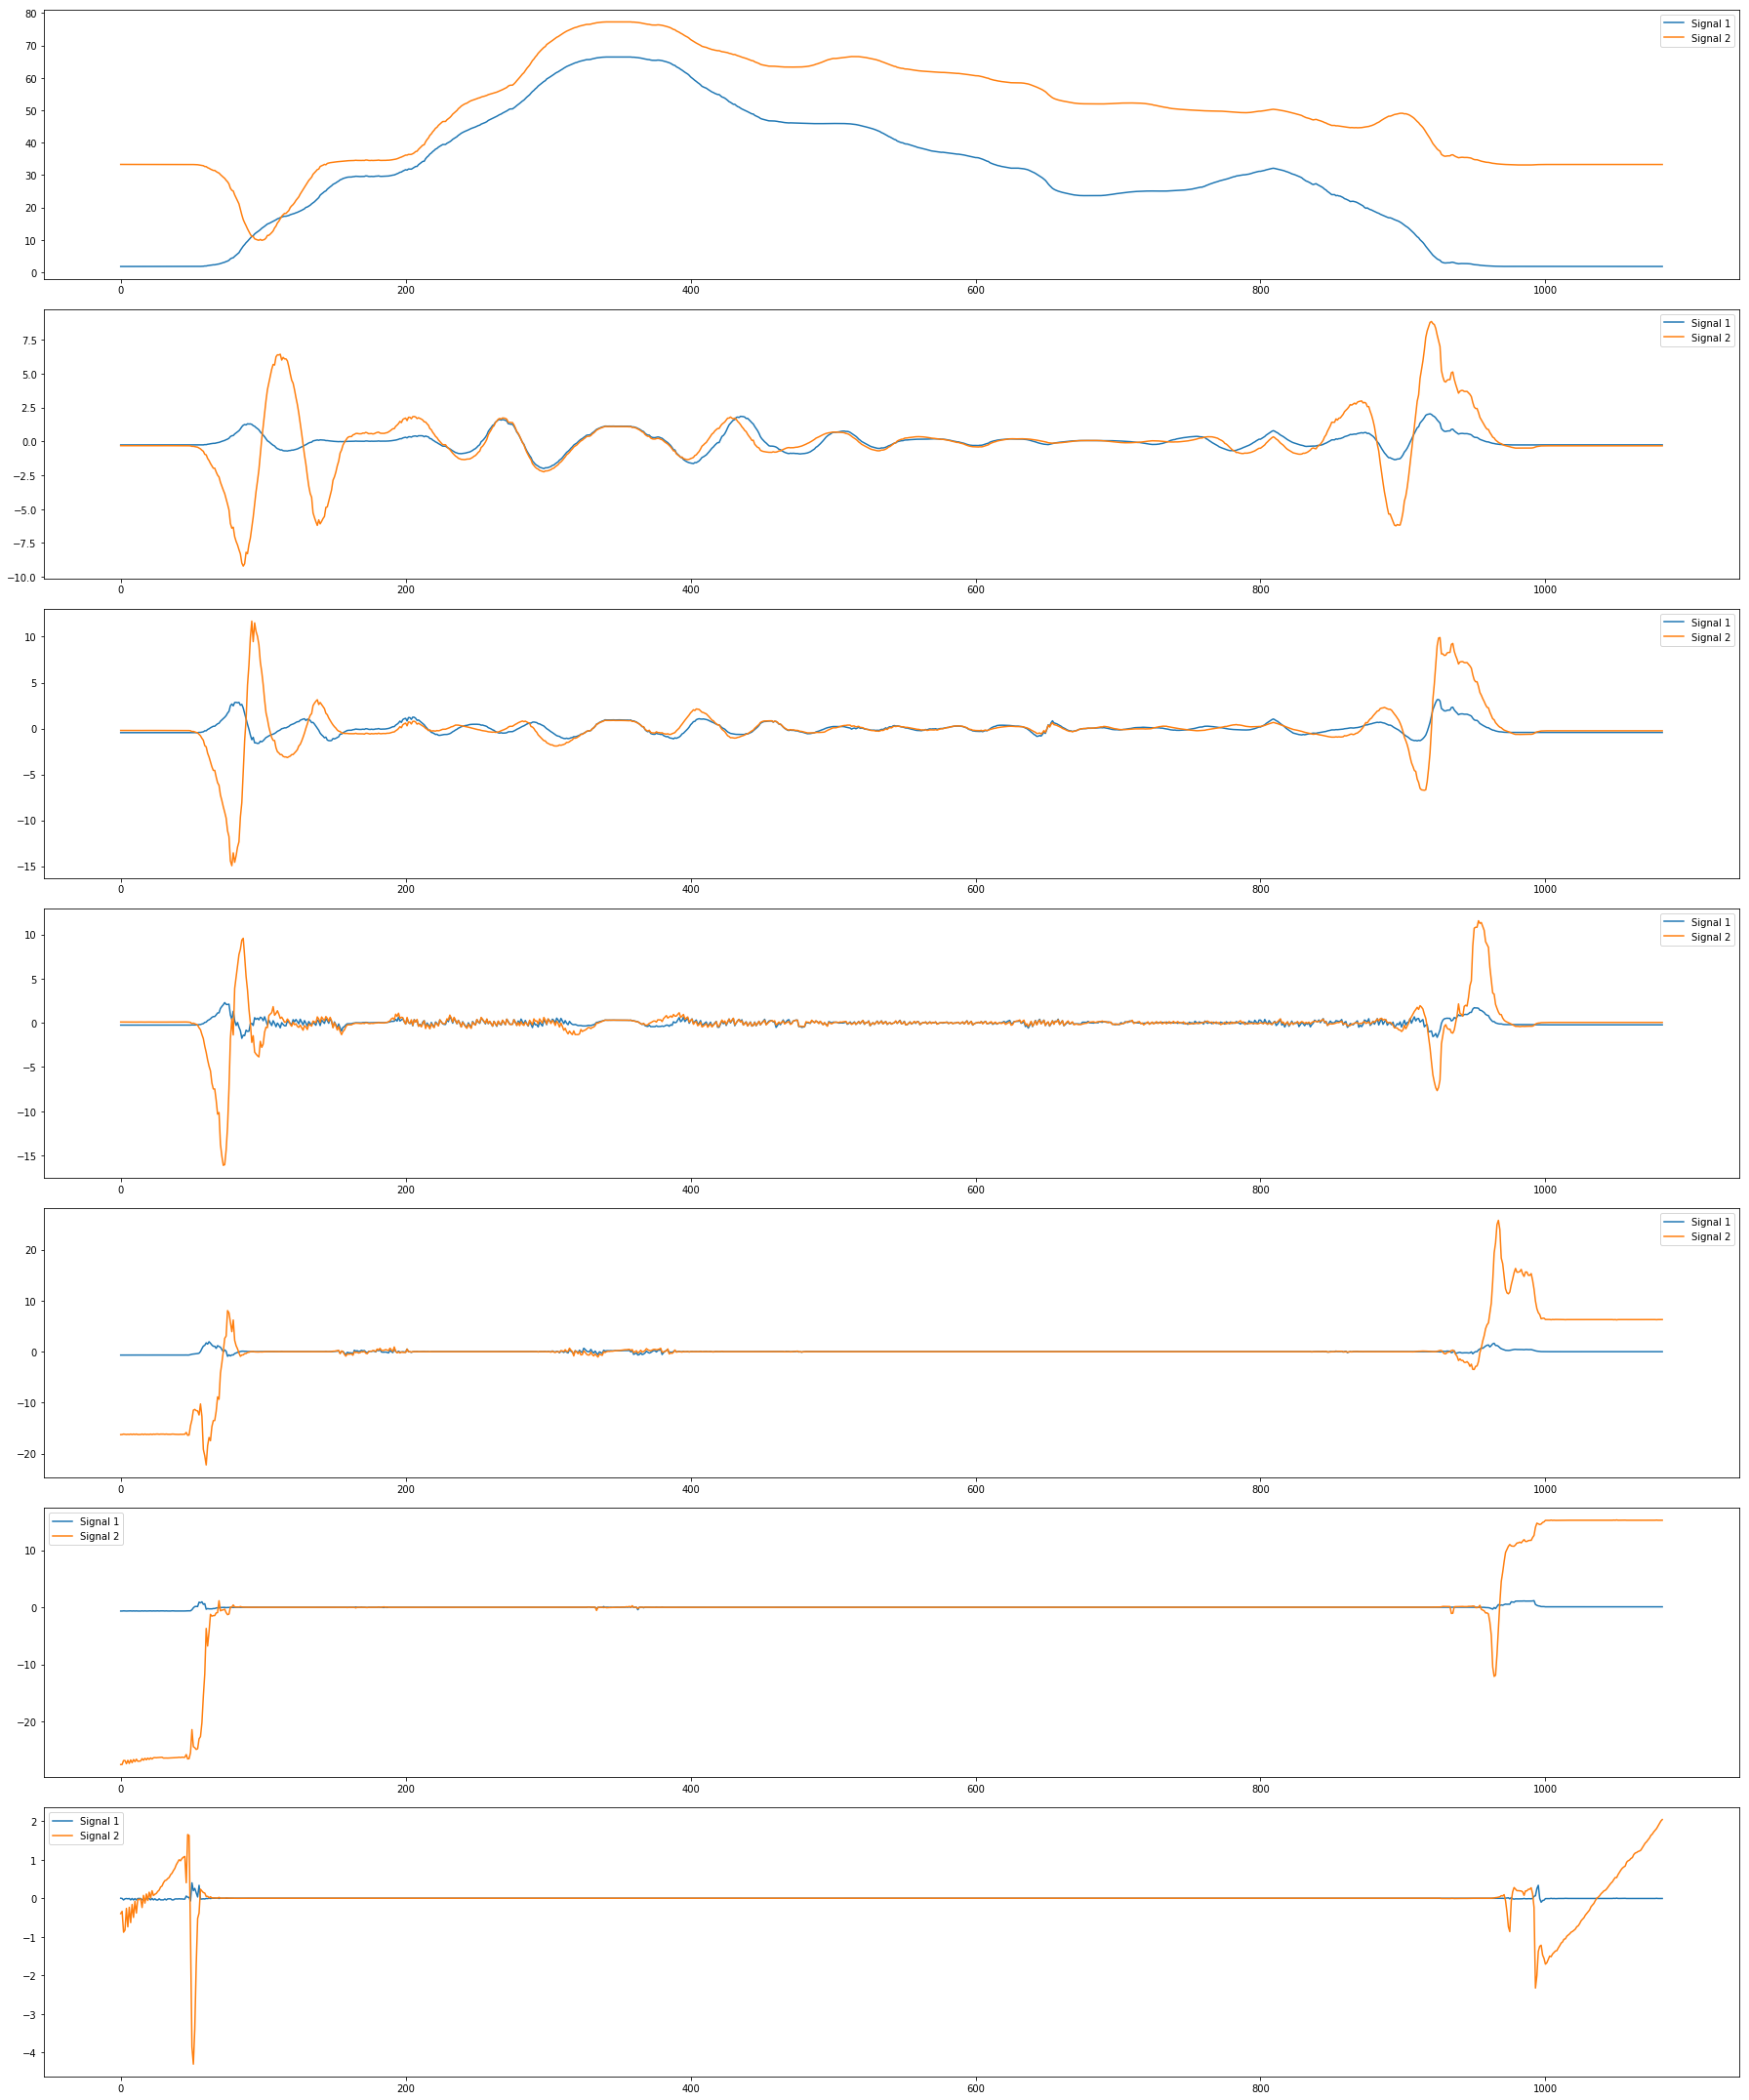

In [241]:
fig, axes = plt.subplots(eval.n_scales, 1, figsize=(25, 30))
#fig.subplots_adjust(hspace=0.5)

for i in range(0, eval.n_scales):
    axes[i].plot(W_1[:,i], label='Signal 1')
    axes[i].plot(W_2[:,i], label='Signal 2')    
    #axes[i].plot(submap_split)
    axes[i].legend()
plt.tight_layout()

----------------------------------------

## Evaluation

In [174]:
n_submaps = 40
submap_size = int(G.N/n_submaps)
print(f"Dividing {G.N} nodes into {n_submaps} = {submap_size} ")

n_all_good = 0
n_low_good = 0
n_high_good = 0
n_no_good = 0

indices = []
submap_indices = []
state_signal = np.zeros((G.N, 1))
for i in range(0, G.N):
    n_indices_in_submap = len(submap_indices)
    
    # If the submap reached max size, evaluate it.
    if n_indices_in_submap > 0 and n_indices_in_submap % submap_size == 0:
        #print(f"Checking submap for indices: {submap_indices}")
        eval_code = eval.check_submap(W_1, W_2, submap_indices)
        if (eval_code is SubmapState.ALL_GOOD):
            n_all_good += 1
            state_signal[submap_indices] = 5
        elif (eval_code is SubmapState.LOW_GOOD):
            n_low_good += 1
            state_signal[submap_indices] = 3
        elif (eval_code is SubmapState.HIGH_GOOD):
            n_high_good += 1
            state_signal[submap_indices] = 1
        else:
            n_no_good += 1
            state_signal[submap_indices] = 0
        #print(f"Submap state code: {eval_code}")
        submap_indices = []
    
    submap_indices.append(i)
    
if len(submap_indices) is not 0:    
    eval_code = eval.check_submap(W_1, W_2, submap_indices)
    if (eval_code is SubmapState.ALL_GOOD):
        n_all_good += 1
        state_signal[submap_indices] = 5
    elif (eval_code is SubmapState.LOW_GOOD):        
        n_low_good += 1
        state_signal[submap_indices] = 3
    elif (eval_code is SubmapState.HIGH_GOOD):
        n_high_good += 1
        state_signal[submap_indices] = 1
    else:
        n_no_good += 1
        state_signal[submap_indices] = 0

fig, axes = plt.subplots(2, 1, figsize=(10, 10))
x = ['ALL_GOOD', 'LOW_GOOD', 'HIGH_GOOD', 'NO_GOOD']
y = [n_all_good, n_low_good, n_high_good, n_no_good]
axes[0].bar(x, y)
G.plot(state_signal, ax=axes[1])

Dividing 1083 nodes into 40 = 27 


AttributeError: 'WaveletEvaluator' object has no attribute 'compute_generic_distance'

In [171]:
all_data = pandas.DataFrame([])

In [223]:
n_submaps = 40
submap_size = int(G.N/n_submaps)
print(f"Dividing {G.N} nodes into {n_submaps} = {submap_size} ")

n_all_good = 0
n_low_good = 0
n_high_good = 0
n_no_good = 0

indices = []
submap_indices = []
state_signal = np.zeros((G.N, 1))

submap_data = []
for i in range(0, G.N):
    n_indices_in_submap = len(submap_indices)
    
    # If the submap reached max size, evaluate it.
    
    if n_indices_in_submap > 0 and n_indices_in_submap % submap_size == 0:        
        features = eval.compute_features_for_submap(W_1, W_2, submap_indices)
        submap_data.append(features)
                
        submap_indices = []
    
    submap_indices.append(i)

Dividing 1083 nodes into 40 = 27 


In [225]:
submap_data = np.array(submap_data)        
label = 1
data=pandas.DataFrame({
    'Cosine_L':submap_data[:,0],
    'Cosine_B':submap_data[:,1],
    'Cosine_H':submap_data[:,2],

    'Euclidean_L':submap_data[:,3],
    'Euclidean_B':submap_data[:,4],
    'Euclidean_H':submap_data[:,5],

    'BrayCurtis_L':submap_data[:,6],
    'BrayCurtis_B':submap_data[:,7],
    'BrayCurtis_H':submap_data[:,8],

    'Correlation_L':submap_data[:,9],
    'Correlation_B':submap_data[:,10],
    'Correlation_H':submap_data[:,11],
    'state':label
})

all_data=all_data.append(data)
print(f"All data has {all_data.shape[0]} rows")
all_data.head()

All data has 640 rows


,Cosine_L,Cosine_B,Cosine_H,Euclidean_L,Euclidean_B,Euclidean_H,BrayCurtis_L,BrayCurtis_B,BrayCurtis_H,Correlation_L,Correlation_B,Correlation_H,state
35,1.490167e-01,0.138298,2.421729,174.945167,49.292310,24.888030,1.686769,1.536610,2.017216,0.006323,0.140770,2.338351,1
36,9.019025e-03,0.301097,1.610457,163.846060,1.906893,63.300180,1.150992,0.602655,1.979297,2.042685,2.992181,3.079333,1
37,1.797574e-06,1.999233,0.268496,163.806937,2.353543,84.852322,1.019238,1.803929,1.974271,2.000208,3.987961,2.644480,1
38,6.782437e-08,1.999973,1.102651,163.806907,2.359056,80.690651,1.018961,1.812959,1.993821,2.001111,3.973952,2.647567,1
39,2.779065e-08,1.999989,1.957235,163.806907,2.358578,85.660387,1.018985,1.812225,1.997913,2.028588,3.761791,3.109131,1


In [247]:
X=all_data[['Cosine_L', 'Cosine_B', 'Cosine_H','Euclidean_L', 'Euclidean_B', 'Euclidean_H','BrayCurtis_L', 'BrayCurtis_B', 'BrayCurtis_H','Correlation_L', 'Correlation_B', 'Correlation_H']]
y=all_data['state']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test

clf=RandomForestClassifier(n_estimators=100)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)

dump(clf, '../config/forest.joblib') 
#clf = load('filename.joblib') 

['../config/forest.joblib']

In [233]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))


Accuracy: 0.9895833333333334


No handles with labels found to put in legend.


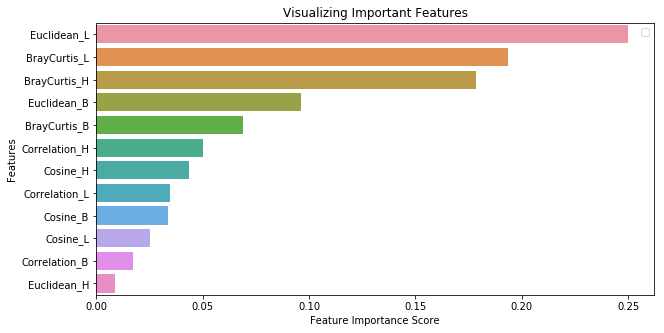

In [235]:
feature_names = ['Cosine_L', 'Cosine_B', 'Cosine_H','Euclidean_L', 'Euclidean_B', 'Euclidean_H','BrayCurtis_L', 'BrayCurtis_B', 'BrayCurtis_H','Correlation_L', 'Correlation_B', 'Correlation_H']
feature_imp = pandas.Series(clf.feature_importances_, index=feature_names).sort_values(ascending=False)

sns.barplot(x=feature_imp, y=feature_imp.index)

# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()


In [240]:
feature_names = ['Cosine_L', 'Cosine_B', 'Cosine_H','Euclidean_L', 'Euclidean_B', 'Euclidean_H','BrayCurtis_L', 'BrayCurtis_B', 'BrayCurtis_H','Correlation_L', 'Correlation_B', 'Correlation_H']

# Pull out one tree from the forest
tree = clf.estimators_[5]
# Export the image to a dot file
export_graphviz(tree, out_file = 'tree.dot', feature_names = feature_names, rounded = True, precision = 1)
# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')
# Write graph to a png file
graph.write_png('tree.png')